## Load necessary modules and data

In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [395]:
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [396]:
genres_df = pd.read_csv('datasets/four_genres.csv')
genres_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Dance,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.0421,0.726,190440,0.554,0.000000,F,0.1060,-5.290,Minor,0.0917,169.999,4/4,0.335
1,Dance,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.5780,0.725,178640,0.321,0.000000,C#,0.0884,-10.744,Minor,0.3230,70.142,4/4,0.319
2,Dance,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,97,0.2970,0.752,201661,0.488,0.000009,F#,0.0936,-7.050,Major,0.0705,136.041,4/4,0.533
3,Dance,Ariana Grande,needy,1TEL6MlSSVLSdhOSddidlJ,92,0.7800,0.647,171573,0.309,0.000007,G,0.2020,-7.948,Minor,0.0366,87.045,4/4,0.195
4,Dance,Ariana Grande,NASA,4uTvPEr01pjTbZgl7jcKBD,91,0.4510,0.747,182000,0.458,0.000000,F#,0.2520,-6.891,Major,0.3030,75.029,4/4,0.470


## Exploration

There are 18 columns, no null-values. Non numeric columns include genre, artist_name, track_name, track_id, key, mode, and time_signature. Some of those (such as track_id) are useless to predict genre. Others, like mode, can be converted to numeric form.

In [346]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36670 entries, 0 to 36669
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             36670 non-null  object 
 1   artist_name       36670 non-null  object 
 2   track_name        36670 non-null  object 
 3   track_id          36670 non-null  object 
 4   popularity        36670 non-null  int64  
 5   acousticness      36670 non-null  float64
 6   danceability      36670 non-null  float64
 7   duration_ms       36670 non-null  int64  
 8   energy            36670 non-null  float64
 9   instrumentalness  36670 non-null  float64
 10  key               36670 non-null  object 
 11  liveness          36670 non-null  float64
 12  loudness          36670 non-null  float64
 13  mode              36670 non-null  object 
 14  speechiness       36670 non-null  float64
 15  tempo             36670 non-null  float64
 16  time_signature    36670 non-null  object

#### Non-numeric features.

There are seven non numerics columns. Four of them identify the song name, song id, artist, artist, and genre. The other three are features of the song: tempo, key, and mode.

In [347]:
genres_df[['track_name', 'artist_name', 'track_id', 'genre']].head(3)

,track_name,artist_name,track_id,genre
0,"break up with your girlfriend, i'm bored",Ariana Grande,4kV4N9D1iKVxx1KLvtTpjS,Dance
1,7 rings,Ariana Grande,14msK75pk3pA33pzPVNtBF,Dance
2,Without Me,Halsey,5p7ujcrUXASCNwRaWNHR1C,Dance


In [348]:
genres_df[['tempo', 'key', 'mode']].head(3)

,tempo,key,mode
0,169.999,F,Minor
1,70.142,C#,Minor
2,136.041,F#,Major


#### Mode column: 

Mode has two categories: Major and Minor, which could be transformed to 1 for Major and 0 for Minor for predictions.

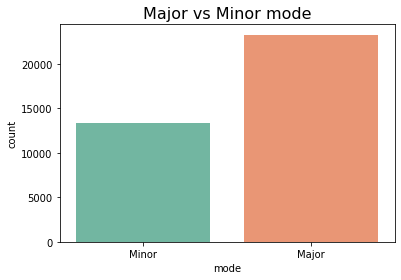

In [349]:
sns.countplot(data=genres_df, x='mode', palette='Set2')
plt.title('Major vs Minor mode', fontsize=16);

#### TIme signature column: 

The most common time signature by far is 4/4. 3/4 has about 5000 counts, and the others are rare. 4/4 is more balanced across genres, while the others show more counts for classical and genres. It might be an idea to transform these categories in a scale from 0 (4/4 most common) to 4.

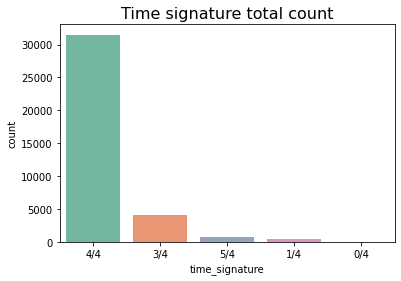

In [350]:
sns.countplot(data=genres_df, x='time_signature',palette='Set2')
plt.title('Time signature total count', fontsize=16);

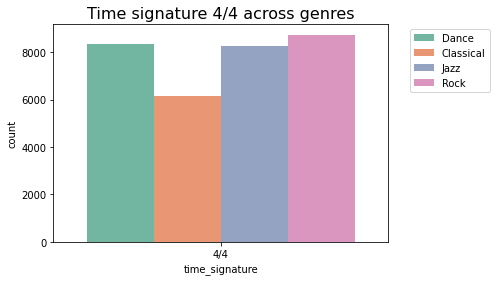

In [351]:
sns.countplot(data=genres_df[genres_df['time_signature']=='4/4'], x='time_signature', hue='genre',palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Time signature 4/4 across genres', fontsize=16);

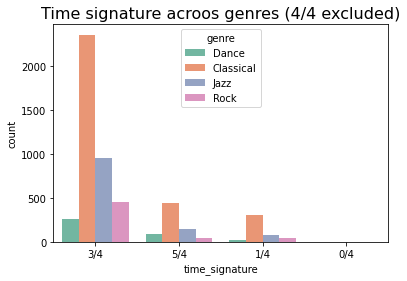

In [352]:
sns.countplot(data=genres_df[genres_df['time_signature']!='4/4'], x='time_signature', hue='genre',palette='Set2')
plt.title('Time signature acroos genres (4/4 excluded)', fontsize=16);

#### Key column:

There are 12 keys: 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#'. It shows some interesting patterns (notably, Jazz have more counts in F and A#), but it is probably better to drop this column for the purpose of this analysis, as there is no direct way to convert these keys to numeric values that make sense.

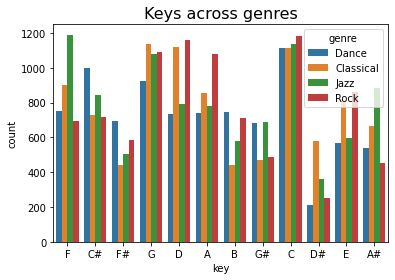

In [353]:
sns.countplot(data=genres_df, x= 'key', hue='genre')
plt.title('Keys across genres', fontsize=16);

In [354]:
print(np.sort(genres_df['key'].unique()))

['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']


#### Numeric colums:

Below we can see historgrams of some of the numeric colums across genres. In ascpects like duration and tempo the distribution appears similar for different genres, while popularity and energy show more variation. It is interesting that the bigger differences are shown in more 'subjective' or 'human related' values, rather than the mathematical values of tempo and duration. On the former columns, dance songs show a high peak around tempo 145 (probably the ideal tempo to dance, not to slow, not too fast), and that the duration of jazz and classical songs varies more.

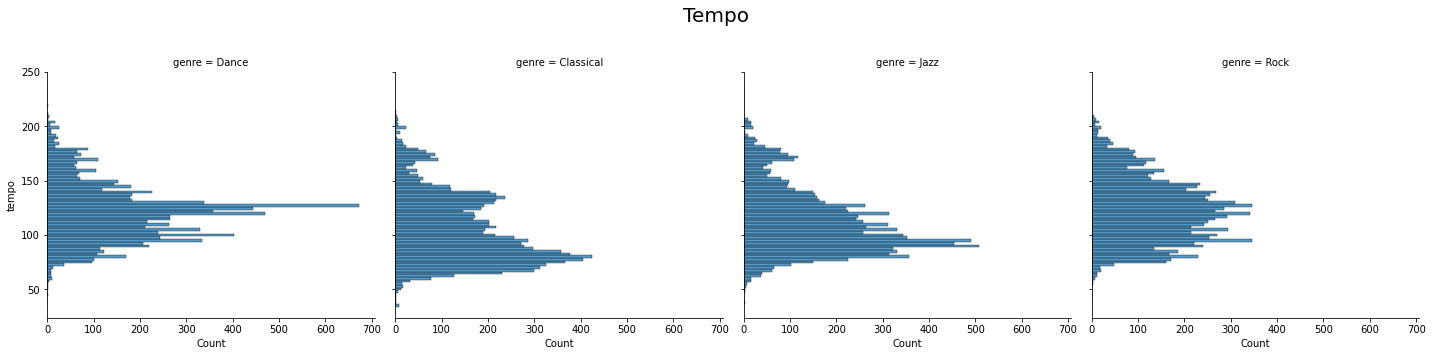

In [355]:
G=sns.displot(data=genres_df, y='tempo', col='genre')
G.fig.subplots_adjust(top=.8)
G.fig.suptitle('Tempo', fontsize=20);

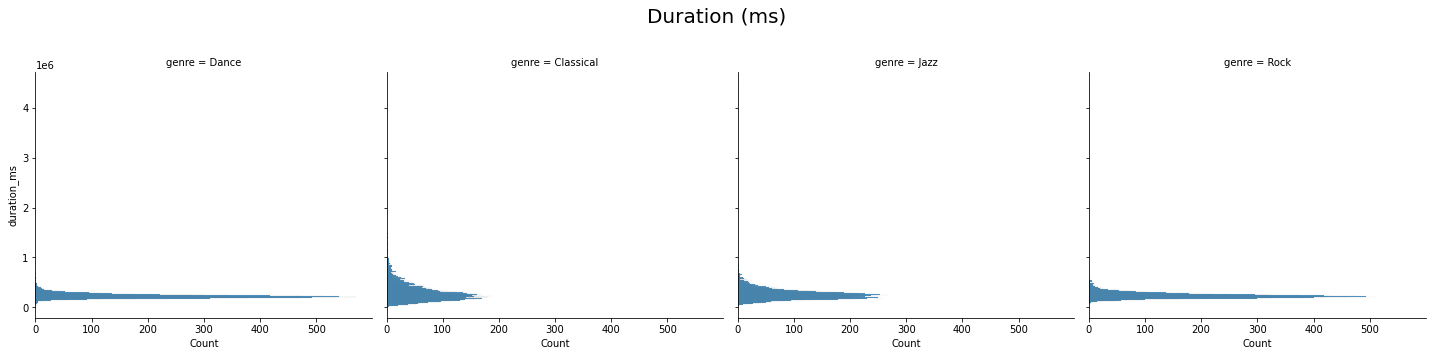

In [356]:
G = sns.displot(data=genres_df, y='duration_ms', col='genre')
G.fig.subplots_adjust(top=.8)
G.fig.suptitle('Duration (ms)', fontsize=20);

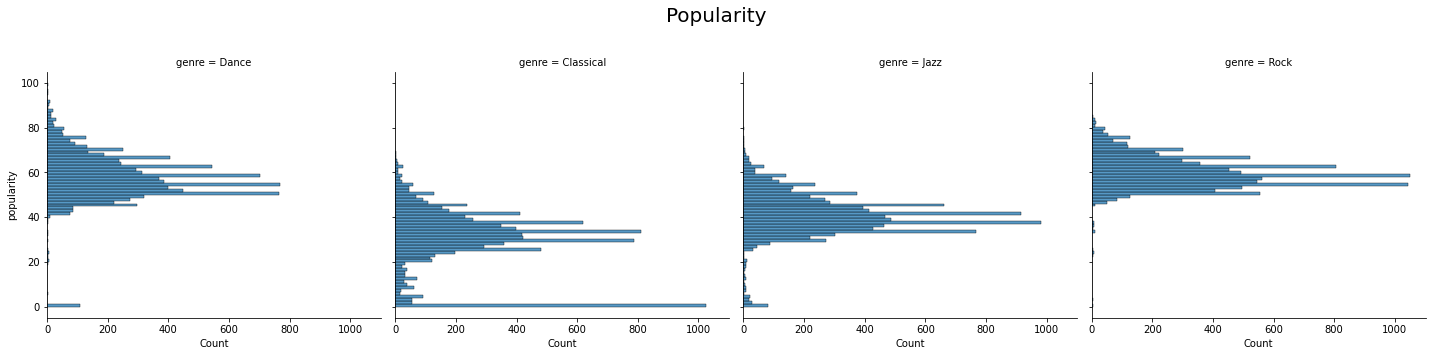

In [357]:
G = sns.displot(data=genres_df, y='popularity', col='genre')
G.fig.subplots_adjust(top=.8)
G.fig.suptitle('Popularity', fontsize=20);

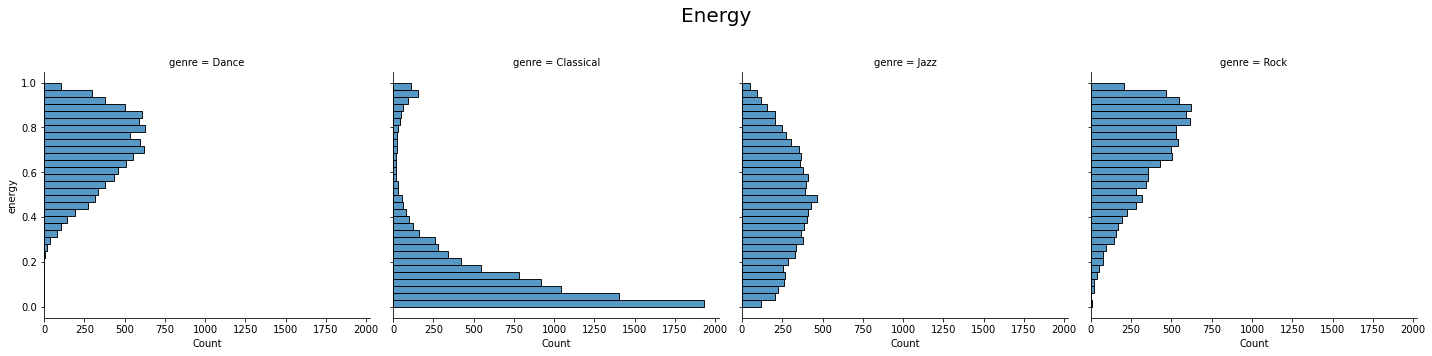

In [358]:
G = sns.displot(data=genres_df, y='energy', col='genre')
G.fig.subplots_adjust(top=.8)
G.fig.suptitle('Energy', fontsize=20);

#### Correlation of numeric columns:

The only columns highly correlated are loudness and energy. It might be  a good idea to drop one of those.

In [359]:
corr_metrics = genres_df.corr()
corr_metrics.style.background_gradient()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
popularity,1.000000,-0.557638,0.395703,-0.181870,0.533840,-0.463405,-0.015336,0.568866,0.027777,0.178003,0.297063
acousticness,-0.557638,1.000000,-0.509820,0.155196,-0.859553,0.505168,-0.100194,-0.785547,-0.135884,-0.261953,-0.441191
danceability,0.395703,-0.509820,1.000000,-0.264801,0.499332,-0.371431,-0.000238,0.571736,0.190372,0.077938,0.640638
duration_ms,-0.181870,0.155196,-0.264801,1.000000,-0.160837,0.189123,0.007308,-0.174406,-0.107187,-0.060936,-0.241732
energy,0.533840,-0.859553,0.499332,-0.160837,1.000000,-0.510639,0.158978,0.870253,0.163761,0.294849,0.539592
instrumentalness,-0.463405,0.505168,-0.371431,0.189123,-0.510639,1.000000,-0.132078,-0.587230,-0.138947,-0.186080,-0.329313
liveness,-0.015336,-0.100194,-0.000238,0.007308,0.158978,-0.132078,1.000000,0.121902,0.127015,0.048343,0.068618
loudness,0.568866,-0.785547,0.571736,-0.174406,0.870253,-0.587230,0.121902,1.000000,0.142730,0.273259,0.492080
speechiness,0.027777,-0.135884,0.190372,-0.107187,0.163761,-0.138947,0.127015,0.142730,1.000000,0.079876,0.132302
tempo,0.178003,-0.261953,0.077938,-0.060936,0.294849,-0.186080,0.048343,0.273259,0.079876,1.000000,0.182284


#### Check for missing values and duplicates

There no null values in the datasets, as the function info() showed before. As for duplicates, there are 871, a 2.37 percent of the observations. Passing value_counts() to the column track_id shows that the máximum of ids duplicated is 2. The list of the first three shows that most of the information for the repeated tracks is the same, but the genre, which in the three cases is Dance and Rock. There is aldso a little difference in popuplarity, but it is minimum. This presents a problem for the analysis, because these duplicates are two genres at once. Since is just a 2.37 percent of the data, one possibility is drop those observations.

In [360]:
print('Number of rows with track id duplicated:'), print(genres_df['track_id'].duplicated().sum());

Number of rows with track id duplicated:
871


In [361]:
print(genres_df[['track_id']].value_counts(). head(5))

track_id              
1FvDJ9KGxcqwv1utyPL3JZ    2
78FHUZRbFDCG6VkRAQdFLm    2
5GxeKtNdjSVAZTfxSsnXhF    2
2QlPByrmEO9XciNBXCrawR    2
4O2aCfXPP9FfPoIPixwVBz    2
dtype: int64


In [362]:
genres_df[genres_df['track_id'].isin(['1FvDJ9KGxcqwv1utyPL3JZ',
                                      '78FHUZRbFDCG6VkRAQdFLm', '5GxeKtNdjSVAZTfxSsnXhF',])].sort_values(by='track_name')

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
2055,Dance,Mr. Mister,Broken Wings,78FHUZRbFDCG6VkRAQdFLm,61,0.13400,0.286,343933,0.500,0.000046,C#,0.1080,-14.281,Minor,0.0357,99.162,4/4,0.443
32895,Rock,Mr. Mister,Broken Wings,78FHUZRbFDCG6VkRAQdFLm,62,0.13400,0.286,343933,0.500,0.000046,C#,0.1080,-14.281,Minor,0.0357,99.162,4/4,0.443
5124,Dance,Future Islands,Ran,5GxeKtNdjSVAZTfxSsnXhF,57,0.00252,0.465,205587,0.701,0.044700,G,0.0683,-6.828,Minor,0.0337,144.931,5/4,0.380
23816,Rock,Future Islands,Ran,5GxeKtNdjSVAZTfxSsnXhF,58,0.00252,0.465,205587,0.701,0.044700,G,0.0683,-6.828,Minor,0.0337,144.931,5/4,0.380
1201,Dance,The Smiths,This Charming Man - 2011 Remaster,1FvDJ9KGxcqwv1utyPL3JZ,72,0.00509,0.611,162920,0.846,0.000000,B,0.0784,-5.900,Major,0.0436,103.912,4/4,0.751
25864,Rock,The Smiths,This Charming Man - 2011 Remaster,1FvDJ9KGxcqwv1utyPL3JZ,73,0.00509,0.611,162920,0.846,0.000000,B,0.0784,-5.900,Major,0.0436,103.912,4/4,0.751


#### Genres of duplicates:

Since in the dataframe the genres are grouped, the duplicated tracks only belong to two genres: Rock and Jazz. To solve this, it is necessary to shuffle the dataframe, so the positions of the genres get mixed. Otherwise, dropping the duplicates could introduce biase against those genres. With the dataframe shuffled, it is clear that most of the trakcs that were given two genres were Dance and Rock songs.

In [363]:
dups = genres_df[genres_df['track_id'].duplicated()]
print(dups['genre'].value_counts())

Rock    791
Jazz     80
Name: genre, dtype: int64


In [364]:
genres_shuffled = genres_df.sample(frac=1, random_state=100)
dups2 = genres_shuffled[genres_shuffled['track_id'].duplicated()]
print(dups2['genre'].value_counts())

Dance        405
Rock         391
Jazz          43
Classical     32
Name: genre, dtype: int64


## Data preparation

#### Dropping duplicated rows

For dropping the duplicates it can be used the index of the¡dups2 dataframe form before, the one made from a shuffle genres_df.
The original dataframe had 36670, now it is reduced to 35799.

In [365]:
genres_df = genres_df.loc[~genres_df.index.isin(dups2.index)]

In [366]:
genres_df.shape

(35799, 18)

#### Checking if the numbers of genres is balanced

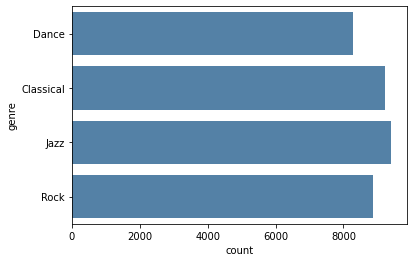

In [367]:
sns.countplot(y="genre", data=genres_df, color='steelblue');

#### Dropping track id, artist name,  key, and track name columns

In [368]:
genres_df = genres_df.drop(['artist_name', 'track_id', 'track_name', 'key'], axis=1)

In [369]:
genres_df.columns

Index(['genre', 'popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

#### Tramforming mode and time signature to numbers

Transforming a binary column with values 'Major' and 'Minor', makes perfect sense. Changing times signatures to 0, 1, 2 3, and 4 is more risky, but may work. There is time to drop that column later. 

In [370]:
print(genres_df['mode'].unique(), genres_df['time_signature'].unique())

['Minor' 'Major'] ['4/4' '3/4' '5/4' '1/4' '0/4']


In [371]:
genres_df['mode'].replace({'Major': 1, 'Minor': 0}, inplace=True)

In [372]:
genres_df['time_signature'].replace({'4/4':0, '3/4': 1, '5/4':2, '1/4':3, '0/4':4}, inplace=True)

In [373]:
print(genres_df['mode'].unique(), genres_df['time_signature'].unique())

[0 1] [0 1 2 3 4]


## Model and Training

#### Split the data in train and test datasets

In [374]:
features = genres_df.drop(['genre'], axis=1).values
labels = genres_df['genre'].values

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=100, test_size=0.3, stratify=labels)

#### Standarization

The features are on different scales. StandardScaler substract mean value of the column from each value and then the values are divided by the standard deviation of the column. The resulting columns have close to normal distribution.

In [375]:
scaler = StandardScaler()
S_train_features = scaler.fit_transform(train_features)
S_test_features = scaler.transform(test_features)

#### Visualizing the explained variance 

Explained_variance_ratio_ is the percentage of variance explained by each component, ordered from higher variance to lower variance. The cumulative sum show the sum of a component explained variance plus the previous. In the graph, an horizontal line shows the 90 % excplained variance.

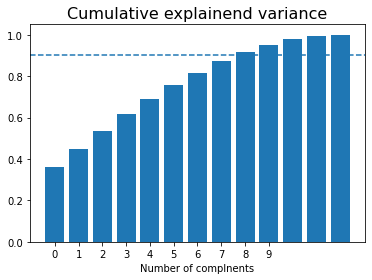

In [392]:
fig, ax = plt.subplots()
ax.bar(range(len(cum_exp_variance)), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.title('Cumulative explainend variance', fontsize=16)
plt.xlabel('Number of complnents');

#### Reduce dimensionality of features to 9

PCA transforms reducing dimensionality with minimal loss of information, removing the redundancy present in data and retains only relevant information. It reduces the computational time required for training the model.

In [378]:
pca = PCA(n_components=9, random_state=100)

train_pca = pca.fit_transform(S_train_features)
test_pca = pca.transform(S_test_features)

#### Train a decision tree, a logistic regression classifier, and a neighbors classifier

The three models preformed similary. About 85% precision predicting Classical genre, 77% Jazz genres, but did not so well with Dance and Rock: arond 60%.

In [379]:
tree = DecisionTreeClassifier(random_state=100)
tree.fit(train_pca, train_labels)

prediction_tree = tree.predict(test_pca)

In [380]:
print(classification_report(test_labels, prediction_tree))

              precision    recall  f1-score   support

   Classical       0.82      0.82      0.82      2767
       Dance       0.53      0.55      0.54      2489
        Jazz       0.67      0.65      0.66      2820
        Rock       0.55      0.55      0.55      2664

    accuracy                           0.65     10740
   macro avg       0.64      0.64      0.64     10740
weighted avg       0.65      0.65      0.65     10740



In [381]:
logreg = LogisticRegression(random_state=100)
logreg.fit(train_pca, train_labels)

prediction_log = logreg.predict(test_pca)

In [382]:
print(classification_report(test_labels, prediction_log))

              precision    recall  f1-score   support

   Classical       0.85      0.87      0.86      2767
       Dance       0.62      0.53      0.57      2489
        Jazz       0.77      0.73      0.75      2820
        Rock       0.59      0.68      0.63      2664

    accuracy                           0.71     10740
   macro avg       0.70      0.70      0.70     10740
weighted avg       0.71      0.71      0.71     10740



In [383]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_pca, train_labels)
prediction_knn = knn.predict(test_pca)

In [384]:
print(classification_report(test_labels, prediction_knn))

              precision    recall  f1-score   support

   Classical       0.87      0.88      0.88      2767
       Dance       0.57      0.62      0.60      2489
        Jazz       0.77      0.75      0.76      2820
        Rock       0.62      0.57      0.60      2664

    accuracy                           0.71     10740
   macro avg       0.71      0.71      0.71     10740
weighted avg       0.71      0.71      0.71     10740



#### Evaluating the models through cross validation

K-fold splits the data into equally sized subsets. Then, it uses each subset as a test set while using the remainder of the data as train sets. In this test Neighbors Classifier performs a little better than the other two.

In [385]:
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=8)), 
                      ("tree", DecisionTreeClassifier(random_state=100))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=8)), 
                        ("logreg", LogisticRegression(random_state=100))])
knn_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=8)), 
                        ("knn", KNeighborsClassifier(n_neighbors=5))])

kf = KFold(10)

tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)
knn_score = cross_val_score(knn_pipe, features, labels, cv=kf)

print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score),
      "Neighbors Classifier:", np.mean(knn_score))

Decision Tree: 0.5419950409043442 Logistic Regression: 0.5461557018673485 Neighbors Classifier: 0.5781949563015794
